In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import import_ipynb
import pandas as pd
from itertools import combinations
from tqdm import tqdm
from esl.chapter03 import LSQR
from esl.chapter03 import BestSelection
from esl.chapter03 import LeastSquaresRegression

In [13]:
class DataGenerator:
    def __init__(self, *args, **kwargs):
        # data params
        self.ndim = kwargs.get('ndim', 11)
        self.ndata = kwargs.get('ndata', 300)
        
        # x params
        self.mu_x = kwargs.get('mu_x', np.zeros(self.ndim))
        cov = 0.85 * np.ones((self.ndim, self.ndim))
        np.fill_diagonal(cov, 1)
        self.cov_x = kwargs.get('cov_x', cov)
        
        # beta params
        self.num_choice = kwargs.get('num_choice', 10)
        self.mu_b = kwargs.get('mu_b', 0.0)
        self.var_b = kwargs.get('var_b', 0.4)
        
        # noise params
        self.mu_n = kwargs.get('mu_n', 0.0)
        self.var_n = kwargs.get('var_n', 6.25)
    
    def get_x(self):
        return np.random.multivariate_normal(self.mu_x, self.cov_x, self.ndata)
    
    def get_beta(self):
        beta = np.zeros(self.ndim)
        beta_index = np.arange(self.ndim)
        
        # this part should be uncommented if we wish to use random beta index
        # self.choice_index = np.random.choice(beta_index, self.num_choice)
        
        self.choice_index = np.arange(self.num_choice)
        beta[self.choice_index] = np.random.normal(
            self.mu_b, 
            np.sqrt(self.var_b), 
            len(self.choice_index)
        )

        return beta

    def get_noise(self):
        return np.random.normal(self.mu_n, np.sqrt(self.var_n), self.ndata)
    
    def get_y(self, x, beta):
        noise = self.get_noise()
        y = x @ beta + noise
        self._get_noise_var(y, noise)
        
        return y
    
    def _get_noise_var(self, y, noise):
        self.sn = np.var(y) / np.var(noise)
    
    def generate(self):
        x = self.get_x()
        beta = self.get_beta()
        y = self.get_y(x, beta)
        return x, y, beta

In [44]:
class ForwardSelection(BestSelection):
    def __init__(self, *args, **kwargs):
        super(ForwardSelection, self).__init__(*args, **kwargs)
            
    def _process_subset(self):
        result = dict()
        result["num_feat"] = []
        result["feat_subset"] = []
        result["RSS"] = []
        
        subsets_remaining = list(self.subsets)
        
        subsets_keep = []
        for subset_size in range(len(self.subsets) + 1):
            subset = list(combinations(subsets_remaining, 1))

            best_RSS = np.inf
            
            if subset_size != 0:
                for feature_index in tqdm(
                    subset,
                    total=len(subset),
                    desc="processing Forward subset: {}".format(subset_size),
                ):
                    RSS_temp = self._fit(subsets_keep + list(feature_index))
                    
                    if RSS_temp < best_RSS:
                        best_RSS = RSS_temp
                        best_feature = feature_index[0]

                subsets_keep.append(best_feature)
                subsets_remaining.remove(best_feature)
                result["RSS"].append(best_RSS)
                result["feat_subset"].append(subsets_keep.copy())
                result["num_feat"].append(subset_size)

            else:
                result["RSS"].append(self._fit(None))
                result["feat_subset"].append('intercept')
                result["num_feat"].append(0)
        
        result = pd.DataFrame(result)
        result = self.get_mallow_cp(result)
        result = self.get_aic(result)
        result = self.get_bic(result)
        return result
    
    def get_mallow_cp(self, result):
        m, p = self.x.shape
        RSS_full = min(result['RSS'])
        sigma_hat_squared = (1/(m - p)) * min(result['RSS'])
        result["Mallow's Cp"] = (1 / m) * (result['RSS'] + 2 * result["num_feat"] * sigma_hat_squared) 
        return result
        
    def get_aic(self, result):
        m, p = self.x.shape
        RSS_full = min(result['RSS'])
        sigma_hat_squared = (1/(m - p -1)) * min(result['RSS'])
        result["AIC"] = (1 / (m * sigma_hat_squared)) * (result['RSS'] + 2 * result["num_feat"] * sigma_hat_squared) 
        return result
        
    def get_bic(self, result):
        m, p = self.x.shape
        RSS_full = min(result['RSS'])
        sigma_hat_squared = (1/(m - p -1)) * min(result['RSS'])
        result["BIC"] = (1 / (m * sigma_hat_squared)) * (result['RSS'] + np.log(m) * result["num_feat"] * sigma_hat_squared) 
        return result
        

In [45]:
num_exp = 1

for exp in range(num_exp):
    datagen = DataGenerator()
    x, y, beta = datagen.generate()
    bs = BestSelection(subsets=np.arange(x.shape[1]))
    result_bs = bs.run(x, y)
    
    fws = ForwardSelection(subsets=np.arange(x.shape[1]))
    result_fws = fws.run(x, y)

processing Forward subset: 11: 100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]


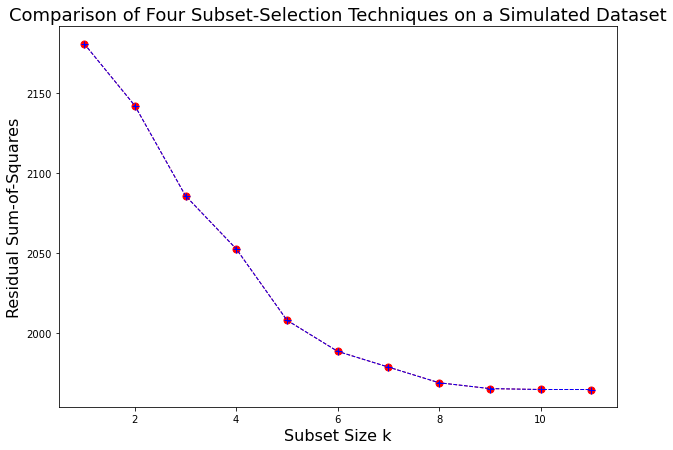

In [46]:
best_subset = result_bs[result_bs.groupby('num_feat')['RSS'].transform(min) == result_bs['RSS']]
plt.figure(figsize=(10, 7))
plt.title('Comparison of Four Subset-Selection Techniques on a Simulated Dataset', fontsize=18)
plt.plot(best_subset['num_feat'][result_bs['num_feat'] != 0], best_subset['RSS'][result_bs['num_feat'] != 0], 'r--o', markersize=7, mfc='red', lw=1)
plt.plot(result_fws['num_feat'][result_fws['num_feat'] != 0], result_fws['RSS'][result_fws['num_feat'] != 0], 'b--+', markersize=7, mfc='blue', lw=1)
plt.xlabel('Subset Size k', fontsize=16)
plt.ylabel('Residual Sum-of-Squares', rotation=90, fontsize=16)
plt.show()

In [47]:
result_fws.head(10)

,num_feat,feat_subset,RSS,Mallow's Cp,AIC,BIC
0,0,intercept,2497.748597,8.325829,1.220380,1.220380
1,1,[6],2180.768764,7.314554,1.072173,1.084519
2,2,"[6, 8]",2142.051456,7.230821,1.059923,1.084614
3,3,"[6, 8, 0]",2085.753613,7.088486,1.039083,1.076120
4,4,"[6, 8, 0, 2]",2052.609551,7.023331,1.029555,1.078939
5,5,"[6, 8, 0, 2, 7]",2008.066320,6.920178,1.014459,1.076188
6,6,"[6, 8, 0, 2, 7, 3]",1988.627963,6.900709,1.011628,1.085703
7,7,"[6, 8, 0, 2, 7, 3, 4]",1978.820301,6.913341,1.013503,1.099924
8,8,"[6, 8, 0, 2, 7, 3, 4, 10]",1969.033993,6.926045,1.015388,1.114155
9,9,"[6, 8, 0, 2, 7, 3, 4, 10, 1]",1965.393841,6.959236,1.020276,1.131389


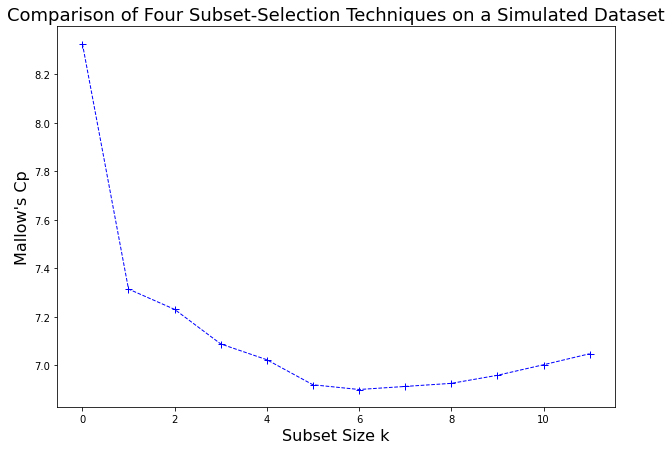

In [49]:
plt.figure(figsize=(10, 7))
plt.title('Comparison of Four Subset-Selection Techniques on a Simulated Dataset', fontsize=18)
plt.plot(result_fws['num_feat'][result_fws['num_feat'] != 0], result_fws["Mallow's Cp"][result_fws['num_feat'] != 0], 'b--+', markersize=7, mfc='blue', lw=1)
plt.xlabel('Subset Size k', fontsize=16)
plt.ylabel("Mallow's Cp", rotation=90, fontsize=16)
plt.show()